<div style="text-align: right"><sub>This notebook is distributed under the <a href="https://creativecommons.org/licenses/by-sa/4.0/" target="_blank">Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license</a>.</sub></div>
<h1>Hands on Machine Learning  <span style="font-size:12px;"><i>by <a href="https://webgrec.ub.edu/webpages/000004/cat/dmaluenda.ub.edu.html" target="_blank">David Maluenda</a></i></span></h1>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://atenea.upc.edu/course/view.php?id=95161" target="_blank">
      <img src="https://github.com/dmaluenda/hands_on_machine_learning/raw/master/resources/upc_logo_49px.png" width="130"/>
    </a>
  </td>
  <td>
  </td>
  <td>   <!-- gColab -->
    <a href="https://colab.research.google.com/github/dmaluenda/hands_on_machine_learning/blob/master/04_Reinforcement_Learning.ipynb" target="_blank">
      <img src="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/resources/colab_logo_32px.png" />
      Run in Google Colab
    </a>
  </td>
  <td>   <!-- github -->
    <a href="https://github.com/dmaluenda/hands_on_machine_learning/blob/master/04_Reinforcement_Learning.ipynb" target="_blank">
      <img src="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/resources/github_logo_32px.png" />
      View source on GitHub
    </a>
  </td>
  <td>   <!-- download -->
    <a href="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/04_Reinforcement_Learning.ipynb"  target="_blank"
          download="04_Reinforcement_Learning">
      <img src="https://raw.githubusercontent.com/dmaluenda/hands_on_machine_learning/master/resources/download_logo_32px.png" />
      Download notebook
      </a>
  </td>
</table>

# $\text{IV}$. Reinforcement Learning

Hands on "Machine Learning on Classical and Quantum data" course of
[Master in Photonics - PHOTONICS BCN](https://photonics.masters.upc.edu/en/general-information)
[[UPC](https://photonics.masters.upc.edu/en) +
[UB](https://www.ub.edu/web/ub/en/estudis/oferta_formativa/master_universitari/fitxa/P/M0D0H/index.html?) +
[UAB](https://www.uab.cat/en/uab-official-masters-degrees-study-guides/) +
[ICFO](https://www.icfo.eu/lang/studies/master-studies)].

**Tutorial 4**

This notebook shows how to:
- solve a challenge with reinforcement learning
- implement the Actor-Critic method
- use a Gradient Tape to train non-conventional loss functions

**References**:

[1] [Keras](https://keras.io/getting_started/): a deep learning API written in Python.<br>
[2] [Keras examples](https://keras.io/examples/rl/).<br>
[3] Gym, a toolkit for developing and comparing reinforcement learning algorithms. By [OpenAI](https://gym.openai.com).

## 0. Imports: NumPy, Matplotlib, Tensorflow and <u>gymnasium</u>

We will use the [Gymnasium](https://gymnasium.farama.org/) module to solve a challenging game. You have to install it before, if you do not already have it, just by run the next cell.

In [ ]:
!pip install gymnasium
!pip install gymnasium[classic-control]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gymnasium as gym

from time import sleep, time

# For simple animation
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

## 1. CartPole game from Farama Foundation gymnasium

We will use the CartPole game. Documentation: https://gymnasium.farama.org/environments/classic_control/cart_pole/

This cell will draw a Figure with a cart and an upstanding pole. This is just a window where to show the current state of the game. Check the two printed lines and the last code line to get familiar with the environ.

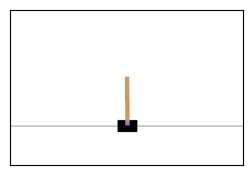

In [5]:
def render(env, rewards=None):
    """ Let's render the environ in a inline Figure, instead of a dedicated window.
        To do so, we need to set the environ mode to 'rgb_array' and imshow the 
        rendered image. To do not acumulate many figures, a clear_ouput is launch first.
    """
    clear_output(wait=True)
    plt.figure(figsize=(3,3))
    plt.title(f"Total rewards: {rewards}") if rewards else None
    plt.imshow(env.render())
    plt.xticks([])
    plt.yticks([])
    plt.show()

env = gym.make("CartPole-v0", render_mode="rgb_array")  # Creates the environment

reset_output = env.reset()
print(f"reset_output: {reset_output}")
state = reset_output[0]
print(f"state: {state}")

render(env)  # This renders the environ

A summary of the documentation's game is:

* **Action Space**

    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.
    
| Num | Action                 |
|-----|------------------------|
|  0  | Push cart to the left  |
|  1  | Push cart to the right |


* **State Space**

    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
    
| Num | Observation           | Min                  | Max                |
|-----|-----------------------|----------------------|--------------------|
| 0   | Cart Position         | -4.8                 | 4.8                |
| 1   | Cart Velocity         | -Inf                 | Inf                |
| 2   | Pole Angle            | ~ -0.418 rad (-24°)  | ~ 0.418 rad (24°)  |
| 3   | Pole Angular Velocity | -Inf                 | Inf                |

* **Rewards**

    Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken, including the termination step, is allotted.


* **Starting State**

    All observations are assigned a uniformly random value in `(-0.05, 0.05)`


* **Episode Termination**

    The episode terminates if any one of the following occurs:
    1. Pole Angle is greater than ±12°
    2. Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    3. Episode length is greater than 200.

Run the `env.step()` function. You have to set an action as argument. Take the returning parameters and print them. What are them? Check https://gymnasium.farama.org/api/env/#gymnasium.Env.step . Pay special attention to the first three returned parameters.

## 2. Neural network player (Actor-Critic Agent)

The Agent in Actor-Critic reinforcement learning is a single NN model with two separated output layers, one for Actor, one for Critic.

* **Actor** tries to decide which action is better for a given environmental state, thus it needs as many output neurons as the actions' space dimension. Also, since just one action can be chosen from the actions' space, at the end, this is like a categorical classification. Therefore, the softmax for the Actor's output is the most appropriated activation function. In this case, we have two possible actions (move to left or to right), then a two softmax neurons as output is the choice.

* **Critic** tries to estimate the total reward obtained from the action just token, according to the current state. Since this is just a number with no defined range, a single output neuron with no activation function (linear) is the best option to the Critic's output layer.

In both cases we use the same input block containing the input layer, with as many neurons as the state's space dimensions. In this case, the model will deal with four dimensional state space.

Additionally, the model can has a common hidden block of any combination of any type of layers. The hidden block is the core of the model, who will process the state of the environ to get valuable information. In this example, a Dense layer of 128 ReLu neurons is enough for the common hidden block.

Define a neural network to be your Agent. Since it needs to have two separated outputs, use the functional approach.

Do not compile the model, since we will train it on our own. Just print the summary to check the layers sizes and connections.

Call your model with the current state from the environ. What Tensor.shape the model expects and returns? Why? How to solve it? Check the [`numpy.newaxis` documentation](https://numpy.org/doc/2.2/reference/constants.html#numpy.newaxis ).

## 3. Playing function

Write a function to play a complete game (episode) of the CartPole using the model as a player. Take as argument a boolean flag to render the game (illustrative purposes) or not (training purposes).

The function have to return the history of the game, useful for training. It is three lists: 1. the partial reward obtained in every step, 2. the probabilities predictions by actor in every step, and 3. the critic values predicted in every step. The three lists have the same size, equal to the number of steps achieved until the game is terminated.

Firstly, the function has to reset the environ and to get the initial state.

Then, make a ***while*** loop until the environ returns `terminated=True`.

Inside the loop:

1. Run your model to get the probabilities from the actor and a value from the critic, according to the current state. Take care of the Tensor shapes.
2. Random choose an action, taking into account the probabilities predicted by the actor. Check the `p` parameter of <u>[numpy.random.choice()](https://numpy.org/doc/2.1/reference/random/generated/numpy.random.choice.html)</u>. This will introduce some noise when probabilities are about fifty-fifty, it is more human. Also, it helps to explore more possibilities while training. This is specially interesting when no action (do nothing) is not an option.
3. Apply the action to the environ with the `step()` function and take the new current state, the reward and if the game has terminated.
4. Render the current environ by calling the `render(env, rewards)` function only if the argument flag is True. Pass the currently cumulated rewards as argument. This is the sum of all previous (and current) rewards. Check the `sum()` function for in-built lists.
5. Populate the returning lists. **The probabilities list has to be populated just with the probability obtained for the action done**, while discarding the probability of other actions not done. 

Finally, return these three history lists.

Run the play function, and print the returned lists. The last is just to realize and check that lists. To avoid many printed lines, you can print the length of the lists and the first four items of them.

## 4. Reinforcement training

We will follow the Actor-Critic algorithm. More information [here](https://medium.com/intro-to-artificial-intelligence/the-actor-critic-reinforcement-learning-algorithm-c8095a655c14). 

<hr>

Remember, we have access to the game's history (episode) through three lists of $T$ number of items:
 * **Action probabilities**: Probability predicted by actor to do that specific action for this certain state: $[\pi_\theta(a|s)]_T = [\pi_\theta(a_0|s_0)\,,\,\dots\,,\, \pi_\theta(a_{T-1}|s_{T-1})]$.
 * **Critic values**: Value predicted by critic: $[V_\phi(s)]_T=[V_\phi(s_0)\,,\,\dots\,,\,V_\phi(s_{T-1})]$.
 * **Rewards**: $+1$ for each step in CartPole: $[r]_T = [r_0\,,\,\dots\,,\,r_{T-1}]$.

There is an extra hyperparameter in Actor-Critic learning called **Discount Factor**: $\gamma$.

<hr>

First, let's define four functions to atomize the whole process:

### 4.1. Discounted Returns (gain)
After an episode finishes, the total discounted return for that episode $G_t$ at each time step $t$ is
\begin{equation}
G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots = \sum_{k=0}^{T-t-1} \gamma^k r_{t+k} \quad\quad\quad \rm{for:}\quad t=0,1,\dots,T-1 
\end{equation}
So, it is the $[G]_T$ gains list of $T$ items.

Write a function to compute the equation above. It should take the $[r]_T$ list of rewards as argument and return a same size list $[G]_T$ for the gains, according to the equation.

$\gamma$ can be an extra argument. For games where more time means better result, it should be near to one. For games where as shorter as better, it should be near to 0. Therefore, let's set it to 0.99 in this case.

### 4.2. Advantage
The advantage $A_t$ indicates how much better an action is compared to the critic's expectation, in a certain $t$ time step:
\begin{equation}
A_t = G_t - V_{\phi}(s_t) \quad\quad\quad \rm{for:}\quad t=0,1,\dots,T-1 
\end{equation}
Again, it is a list of $T$ items.

Write a function to calculate the Advantage the Actor takes from the Critic. Take the $[r]_T$ rewards list and the $[V_\phi(s)]_T$ critic's predictions list from the arguments, compute the discounted returns $[G]_T$ using the function you have just created and compute the $[A]_T$ advantage list.

### 4.3. Actor Loss 
The actor loss is defined to maximize the policy performance. Since the Actor has to decide an action, this is a categorical classification problem, where there is just one good action to be applied, the best choice. For that reason, we have used a softmax activation function. Then, the loss function for this is the categorical cross-entropy. However, we have no ground truth, since we have no direct access to the real better action. Then, the critic is a workaround to be able to compute a "ground truth" for the cathegorical cross-entropy, the Advantage. Because, by minimizing the negative log-probability of selected actions weighted by the advantage, we will train the Actor to get better than the critic. Therefore, the Advantage is calculated as:
\begin{equation}
L_{\text{actor}}(\theta) = -\frac{1}{T}\sum_{t=0}^{T-1}\log \pi_{\theta}(a_t|s_t) \cdot A_t
\end{equation}

Write a function to calculate the actor loss. Take as argument the $[r]_T$ rewards lists, the $[\pi_\theta(a|s)]_T$ probabilities predictions list, and the $[V_\phi(s)]_T$ critic's predictions list. Compute the $[A]_T$ advantage using the function you have just written. Finally, take into account the $L_\text{actor}$ actor's loss has to be just an average number.

To make the logarithm, use the `tensorflow.keras.ops.log()` function, since it is more appropiated for `tf.Tensor` variables type.

### 4.4. Critic Loss
The critic just wants to predict the final reward that a certain action will gain for a certain state. Therefore, it wants to replicate the discounted return (gain). Thus, an MSE between the $[V_\phi(s)]_T$ predicted values and the $[G]_T$ gain is a good loss function to it:
\begin{equation}
L_{\text{critic}}(\phi) = \frac{1}{T}\sum_{t=0}^{T-1}\left(G_t - V_{\phi}(s_t)\right)^2
\end{equation}

Write a function to compute the averaged Critic's loss from the $[r]_T$ rewards list and the $[V_\phi(s)]$ critic's predictions list.

OK, now let's use all this functions to compute the gradients and train the model.

<hr>

### 4.5 Learning loop

We will use the `Adam` optimizer from `keras.optimizers`.

Since we will manually apply the gradients using [its own funciton](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam#apply), we do not need to compile the model with this optimizer, but we just need to define a variable with this optimizer with a certain learning rate, e.g. $\eta=0.005$.

Let's train the model just by playing some (or many) complete games and learning from the rewards obtained.

Do a *while* loop until the game is considered solved by the model. This is when it reaches 200 points for a single play (episode), i.e. `points`$=\sum_{t=0}^T r_t$.

Then, in the ***while loop***:

1. Open a `tenosrflow.GradinetTape()` using a `with ... as ... :` block (https://www.tensorflow.org/guide/autodiff). This will store all tf.Tensor values during the play (forward pass through the model) to be able to compute the gradient (backpropagation).
   * Inside the `with_as` block:
     1. Play a complete game using the function done in section 3 and get the lists of rewards, probability prediction, and critic predictions for the current episode. Pass a `False` for the rendering flag, expect every 10 training loops (episodes), since it takes time. So, to avoid rendering the environ for all episodes will speed up the training.
     2. Get the actor and critic losses using the functions done before with the returned lists by the playing function.
     3. Compute the total loss as the sum of the Actor's loss and the Critic's loss.
<br>
<br>
2. Compute the gradient using `tape.gradient(loss, variables)`, where `loss` is the total loss computed inside the `with_as` block, and `variables` are the trainable variables of your model (`model.trainable_variables`). It returns the gradient.
<br>
<br>
4. Apply the gradient to the model using the Adam optimizer defined above, using the `apply(grad, variables)` function of your optimizer, where `grad` is the gradient returned by the tape and `variables` are again those trainable variables of your model.
<br>
<br>
5. Check the total obtained `points` in this current episode, and print it. Use `print(points, end=', ')` to avoid many printed lines.
<br>
<br>
6. Store the total obtained points in a history list.

Plot the history to check the evolution.

## 5. Checking the model

Play again a complete game calling the function written in section 1.3 and check its behavior and the total reward obtained.

In some cases, the model reaches the target rewards during the training just by luck. Check the obtained points' evolution. If it is consistent, probably you have just gotten a good behavior in this last play. However, if it suddenly reached the maximum, probably it was by luck.

If the last, you can re-run the learning cell. It will continue with the training, not from the beginning, just continuing.